In [10]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import openpnm as op

%matplotlib notebook

In [3]:
"""
Params
"""
SPACING = 0.0001

"""
Network
"""
pn = op.network.Cubic(shape=[10, 10, 10], spacing=SPACING)

"""
Geometry
"""
geo = op.geometry.StickAndBall(network=pn, pores=pn.pores(), throats=pn.throats())

"""
Phases
"""
water = op.phases.Water(network=pn)

"""
Physics
"""
phys_water = op.physics.GenericPhysics(network=pn,phase=water, geometry=geo)

"""
Model
"""
model = op.models.physics.hydraulic_conductance.hagen_poiseuille
phys_water.add_model(propname = 'throat.hydraulic_conductance',
                    model = model,
                    pore_viscosity = 'pore.viscosity',
                    pore_area = 'pore.area',
                    throat_area = 'throat.area')

In [15]:
"""Invasion percolation"""
shape = [50,50,1]
pn = op.network.Cubic(shape = shape, spacing=0.0001)
geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts) # https://openpnm.readthedocs.io/en/master/modules/geometry/index.html
water = op.phases.Water(network=pn)
water.add_model(propname = 'throat.entry_pressure',
                model = op.models.physics.capillary_pressure.washburn)
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=water)
ip.set_inlets(pores=pn.pores('left'))
ip.run()



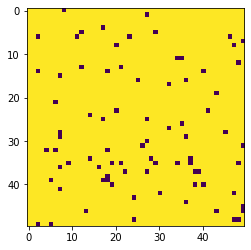

In [4]:
water.update(ip.results(Snwp = 0.98))

# plot sequence
#plt.imshow(sp.reshape(ip['pore.invasion_sequence'], newshape=shape[:-1]))

# plot final state
plt.imshow(sp.reshape(water['pore.occupancy'], newshape=shape[:-1]))

In [11]:
"""Drainage (percolation) + ch4 diffusion following paper"""

SPACING = 0.0001
shape = [100,100,1]
pn = op.network.Cubic(shape = shape, spacing=SPACING)

geom = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts) # https://openpnm.readthedocs.io/en/master/modules/geometry/index.html

ch4 = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)

ch4.add_model(propname = 'throat.diffusive_conductance',
                  model = op.models.physics.diffusive_conductance.ordinary_diffusion)
water.add_model(propname = 'throat.entry_pressure',
                model = op.models.physics.capillary_pressure.washburn)
# water percolation
o_perco = op.algorithms.OrdinaryPercolation(network = pn)
o_perco.setup(phase = water, access_limited = True)
o_perco.set_inlets(pores = pn.pores('back')) # where water will entry from
o_perco.set_outlets(pores = pn.pores('front')) # where ch4 will exit
o_perco.run()




―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.OrdinaryPercolation.set_inlets 
    TIME STAMP: 2019-10-28 16:36:02,680    


5280.383978312896


<IPython.core.display.Javascript object>


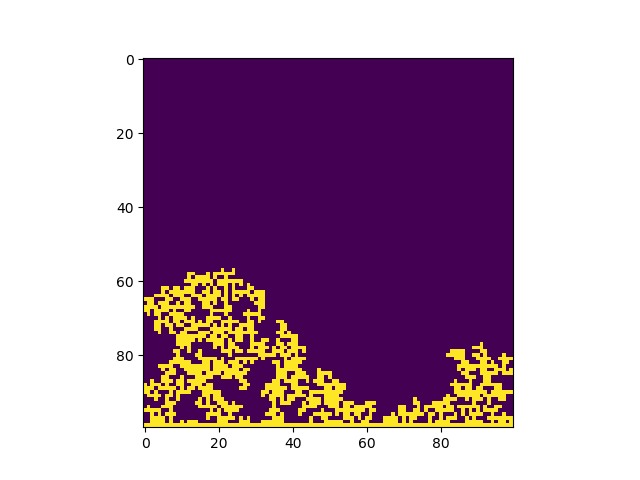

In [12]:
percolating_threshold = o_perco.get_percolation_threshold()
#o_perco.plot_intrusion_curve(fig=fig) is broken, doesn't work
#print(o_perco.keys()) # get keynames for stored results
print(percolating_threshold)
pressure = percolating_threshold-20
water.update(o_perco.results(Pc = pressure))
plt.imshow(sp.reshape(water['pore.occupancy'], newshape=shape[:-1]))


In [13]:
"""Fickian diffusion transient"""

ch4['throat.conductance'] = ch4['throat.diffusive_conductance'] * (o_perco['throat.invasion_pressure'] > pressure)


fick_diffusion = op.algorithms.TransientFickianDiffusion(network = pn)
fick_diffusion.setup(phase = ch4, conductance = 'throat.conductance')

# BC and IC
# pores potentially producing CH4 are waterlogged and neighbors
waterlogged_pores = pn.pores()[water['pore.occupancy']==1]
neighbors = pn.find_neighbor_pores(waterlogged_pores)
pores_producing_ch4 = np.concatenate((waterlogged_pores, neighbors ))
pores_producing_ch4 = np.unique(pores_producing_ch4) # take outduplicated


FRAC_CH4_TOP = 0.0; FRAC_CH4_BOTTOM = 1.0
fick_diffusion.set_value_BC(pores = pn.pores('front'), values = FRAC_CH4_TOP)
fick_diffusion.set_value_BC(pores = pores_producing_ch4, values = FRAC_CH4_BOTTOM)
fick_diffusion.set_IC(0.0)

# time-related parameters
fick_diffusion.setup(t_scheme = 'cranknicolson', t_final = 100, t_output = 0.01, t_step = 0.01, t_tolerance = 1e-12)


fick_diffusion.run()
print(fick_diffusion)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : alg_02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_rate                                      0 / 10000
2     pore.bc_value                                  2175 / 10000
3     pore.concentration                            10000 / 10000
4     pore.concentration@0                          10000 / 10000
5     pore.concentration@11e-2                      10000 / 10000
6     pore.concentration@12e-2                      10000 / 10000
7     pore.concentration@13e-2                      10000 / 10000
8     pore.concentration@14e-2                      10000 / 10000
9     pore.concentration@15e-2                      10000 / 10000
10    pore.concentration@16e-2                    

<IPython.core.display.Javascript object>


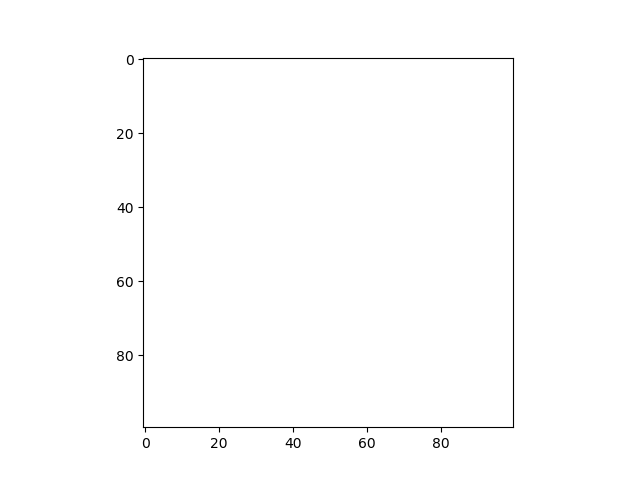

In [14]:
"""Animation of Transport Fickian using matplotlib"""
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(1,9,2):
    im = plt.imshow(fick_diffusion['pore.concentration@' + str(i) + 'e-2'].reshape(shape[:-1]), 
                    animated=True, vmin = 0, vmax = 1)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=2000, blit=False, repeat_delay=1000)

plt.show()


ani.save(filename = 'diff_movie.mp4')

ModuleNotFoundError: No module named 'ffmpeg'

In [ ]:

"""
Save figs
"""

op.io.VTK.save(network = pn, phases = water, filename = 'test3d_percolation')